In [1]:
%matplotlib notebook

import os
import time
import numpy as np
import matplotlib as mpl

from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt

from labtools import mplplots; reload(mplplots)
from labtools.mplplots.init_nb_plotting import *
from labtools.mplplots import tools as mpltools

import qcodes as qc
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import DataSet
from qcodes.sweep import sweep, nest, chain, szip, getter, setter
from qcodes.sweep.sweep import ParameterSweep, Nest, ParameterWrapper, FunctionWrapper, FunctionSweep, getter
from pytopo.qctools import instruments as instools

from v2_dataset_tools.experiments import do_experiment, get_results_from_db_path

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from scipy import constants
from scipy.interpolate import interp1d
from scipy.optimize import fmin
from scipy.integrate import cumtrapz

In [3]:
from qcodes.dataset.sqlite_base import transaction, one

def get_timestamp(run_id):
    DB = qc.config["core"]["db_location"]
    
    d = DataSet(DB)
    sql = """
    SELECT run_timestamp
    FROM
      runs
    WHERE
      run_id= ?
    """
    c = transaction(d.conn, sql, run_id)
    run_timestamp = one(c, 'run_timestamp')
    return run_timestamp

def timestamp_to_fmt(ts, fmt):
    return time.strftime(fmt, time.gmtime(ts))

def img_basepath(run_id):
    ts = get_timestamp(run_id)
    return timestamp_to_fmt(ts, qc.config['user']['img_dir'] + str(run_id).zfill(4) + '_')

def ds_title(run_id):
    return "{} #{}".format(os.path.abspath(qc.config['core']['db_location']), run_id)

qc.config['user']['img_dir'] = "d:/data/images/%Y-%m/%Y-%m-%d/"
qc.config.save_to_cwd()

In [7]:
from qcodes.instrument_drivers.stanford_research.SR860 import SR860
sr1 = instools.create_inst(SR860, "sr1", "GPIB0::4::INSTR")

from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
key1 = instools.create_inst(Keysight_34465A, "key1", "TCPIP0::169.254.162.148")
key2 = instools.create_inst(Keysight_34465A, "key2", "TCPIP0::169.254.171.210")
key3 = instools.create_inst(Keysight_34465A, "key3", "TCPIP0::169.254.4.61")

from qcodes.instrument_drivers.rohde_schwarz.SGS100A import RohdeSchwarz_SGS100A
RF = instools.create_inst(RohdeSchwarz_SGS100A, 'RF', address="TCPIP0::169.254.251.130")

from qcodes.instrument_drivers.yokogawa.GS200 import GS200
yoko = instools.create_inst(GS200, 'yoko', address="USB0::0x0B21::0x0039::91TC01026::INSTR")

station = qc.Station(yoko, key1, key2, key3, RF, sr1)

C:\ProgramData\Anaconda3\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)
Snapshot: Could not update parameter:current_range
Snapshot: Could not update parameter:current


Instrument sr1 already exists.
Instrument key1 already exists.
Instrument key2 already exists.
Instrument key3 already exists.
Instrument RF already exists.
Instrument yoko already exists.


## Test measurements
Setup1: yokogawa biasing a 1M resistor, read out with DL pre-amp set to 1E6 gain measured with key3

Setup2: sr1 biasing (AC+DC) 1 16k resistor, read out with DL pre-amp set to 1E6 gain measured with sr1 and key2

In [8]:
station.sr1.amplitude()

C:\ProgramData\Anaconda3\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


9.9999997474e-06

In [16]:
@getter([('raw_voltage', 'V'), ('current', 'A')])
def measure_dc_only(gain=1e6):
    time.sleep(0.02 * key3.NPLC()) 
    key3_raw = key3.volt()
    current = -key3_raw/gain
    result = key3_raw, current
    return result

@getter([('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'), ('L1X', 'V'), ('L1Y', 'V')])
def measure_acdc(gain=1e6, Rseries=0):
    time.sleep(.1 * key2.NPLC()) 
    key2_raw = key2.volt()
    current_dc = -key2_raw/gain
    L1X     = sr1.X()
    L1Y     = sr1.Y()
    current_ac = -L1X/gain
    Vac     = sr1.amplitude()*np.sqrt(2) #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830
    g       = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    result  = current_dc, key2_raw, g, L1X, L1Y
    return result

C:\ProgramData\Anaconda3\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


<IPython.core.display.Javascript object>


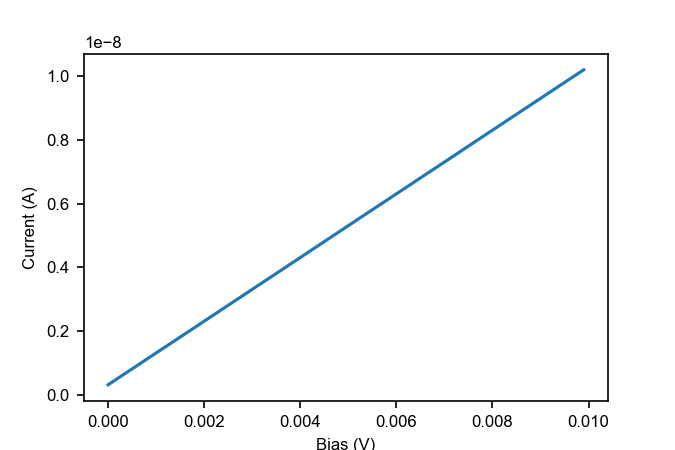

Starting experimental run with id: 38
Completed measurement. Database path: SanityChecks/John20180331/0


In [41]:
setup = [(lambda: None, tuple())]
cleanup = [(lambda: None, tuple())]

key1.NPLC(1)
key2.NPLC(1)

g_bias = 1e-3
#sr1.amplitude(2.5*1e-6/(np.sqrt(2)*1e-2*g_bias))
#sr1.frequency(18.3)
#sr1.time_constant(.1)

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "SanityChecks/John20180331",
    setup,
    nest(
#         sweep(lockin1.frequency, np.linspace(1,60,401)),
        sweep(yoko.voltage, np.linspace(0, 10e-3, 101)),
        measure_dc_only
    ),
    cleanup,
    return_format=["data_set_path", "dataset"], 
    live_plot_axes=[{"Bias (V)": 0, "Current (A)": 2}]
)

## Now pull the data back out of the dataset database to plot whichever column you want

In [43]:
path, ds = result
dv = get_results_from_db_path(path)
dataid = ds.run_id

In [45]:
v = np.array(dv.get_values('yoko_voltage'))[:,0]
i = np.array(dv.get_values('current'))[:,0]
raw_voltage = np.array(dv.get_values('raw_voltage'))[:,0]

<IPython.core.display.Javascript object>


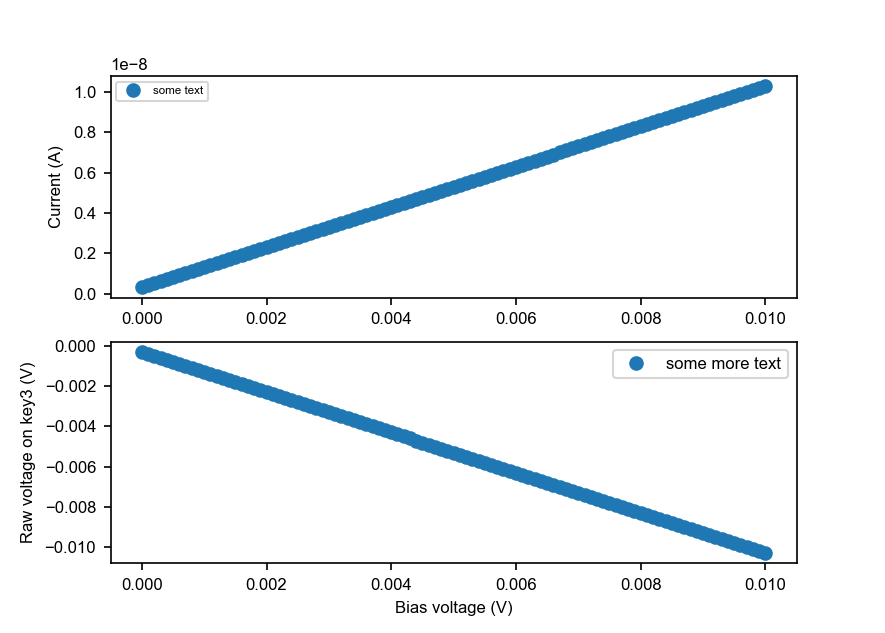

In [52]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(4, 2))

ax1.plot(v, i, 'o',label="some text")
ax2.plot(v, raw_voltage, 'o', label="some more text")
ax1.legend(loc='upper left', fontsize='x-small')
ax1.set_ylabel('Current (A)')
ax2.set_xlabel('Bias voltage (V)')
ax2.set_ylabel('Raw voltage on key3 (V)')
ax2.legend()


## Now measure differential conductance with the lock-in

In [17]:
sr1.sine_outdc()

C:\ProgramData\Anaconda3\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


0.0099999997765

C:\ProgramData\Anaconda3\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


<IPython.core.display.Javascript object>


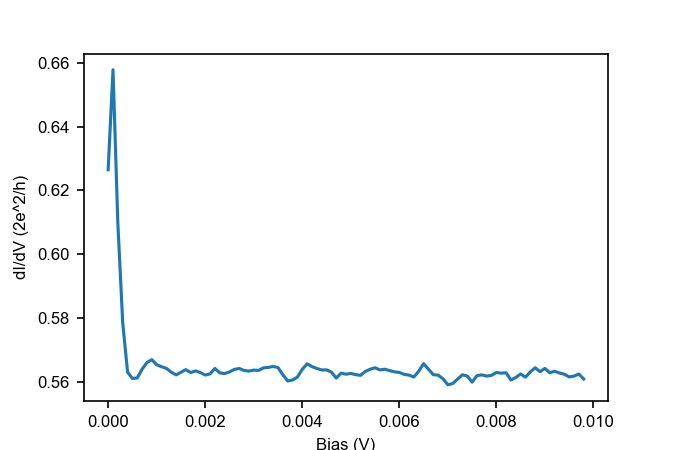

Starting experimental run with id: 55
Completed measurement. Database path: SanityChecks/John20180331/17


In [18]:
setup = [(lambda: None, tuple())]
cleanup = [(lambda: None, tuple())]

key2.NPLC(1)

g_bias = 10e-6
sr1.amplitude(g_bias)
sr1.frequency(30.3)
sr1.time_constant(.1)

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "SanityChecks/John20180331",
    setup,
    nest(
#         sweep(lockin1.frequency, np.linspace(1,60,401)),
        sweep(sr1.sine_outdc, np.linspace(0, 10e-3, 101)),
        measure_acdc
    ),
    cleanup,
    return_format=["data_set_path", "dataset"], 
    live_plot_axes=[{"Bias (V)": 0, "dI/dV (2e^2/h)": 3}]
)

In [21]:
path, ds = result
dv = get_results_from_db_path(path)
dataid = ds.run_id

In [22]:
dv

results #55@./experiments.db
----------------------------
sr1_sine_outdc - numeric
current - numeric
raw_voltage_dc - numeric
conductance - numeric
L1X - numeric
L1Y - numeric

In [23]:
dc_bias = np.array(dv.get_values('sr1_sine_outdc'))[:,0]
dc_current = np.array(dv.get_values('current'))[:,0]
didv = np.array(dv.get_values('conductance'))[:,0]
L1X = np.array(dv.get_values('L1X'))[:,0]
L1Y = np.array(dv.get_values('L1Y'))[:,0]

<IPython.core.display.Javascript object>


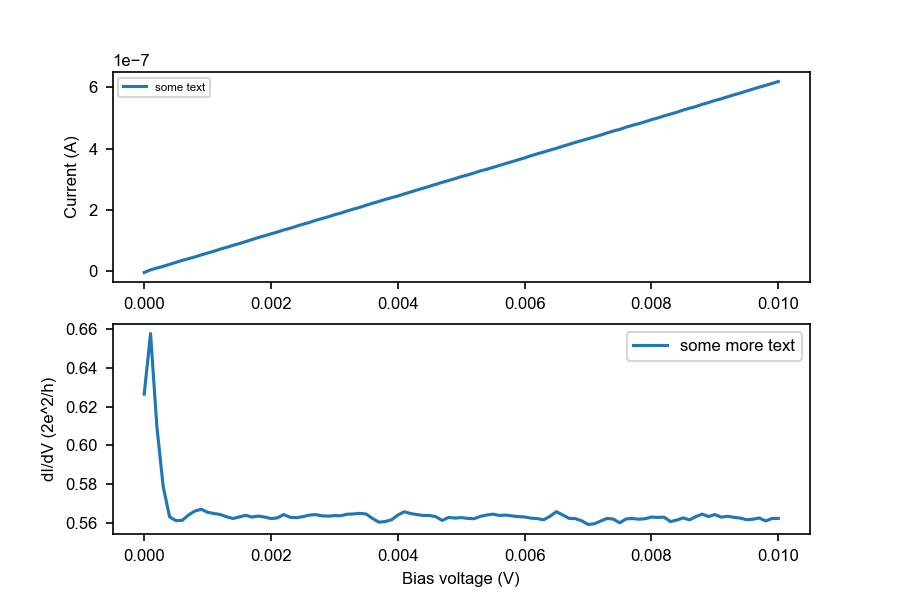

In [25]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(6, 4))

ax1.plot(dc_bias, dc_current ,label="some text")
ax2.plot(dc_bias, didv, label="some more text")
ax1.legend(loc='upper left', fontsize='x-small')
ax1.set_ylabel('Current (A)')
ax2.set_xlabel('Bias voltage (V)')
ax2.set_ylabel('dI/dV (2e^2/h)')
ax2.legend()

In [98]:
print('dV/dI ~ ' + str(25812*0.56) + ' Ohms')
print('Numerical dV/dI ~ ' + str(0.01/6.2e-7) + ' Ohms')

dV/dI ~ 14454.720000000001 Ohms
Numerical dV/dI ~ 16129.032258064517 Ohms


## Simple RF
Setup RF readout with a homodyne measurement, record in-phase component with key1

In [10]:
@getter([('voltage', 'V')])
def measure_rf():
    time.sleep(.1 * key1.NPLC()) 
    V_reflect = key1.volt()
    result  = V_reflect
    return result

C:\ProgramData\Anaconda3\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


<IPython.core.display.Javascript object>


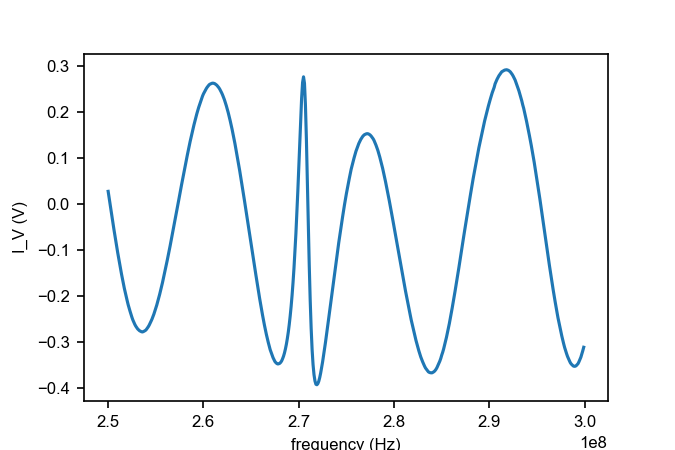

Starting experimental run with id: 54
Completed measurement. Database path: SanityChecks/John20180331/16


In [15]:
setup = [(lambda: None, tuple())]
cleanup = [(lambda: None, tuple())]

key1.NPLC(1)

RF.power(13)

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "SanityChecks/John20180331",
    setup,
    nest(
#         sweep(lockin1.frequency, np.linspace(1,60,401)),
        sweep(RF.frequency, np.linspace(250e6, 300e6, 501)),
        measure_rf
    ),
    cleanup,
    return_format=["data_set_path", "dataset"], 
    live_plot_axes=[{"frequency (Hz)": 0, "I_V (V)": 1}]
)

In [7]:
path, ds = result
dv = get_results_from_db_path(path)
dataid = ds.run_id

In [8]:
dv

results #51@./experiments.db
----------------------------
RF_frequency - numeric
voltage - numeric

In [10]:
frequency = np.array(dv.get_values('RF_frequency'))[:,0]
V_ref = np.array(dv.get_values('voltage'))[:,0]
P_ref = np.log10(V_ref**2)

<IPython.core.display.Javascript object>


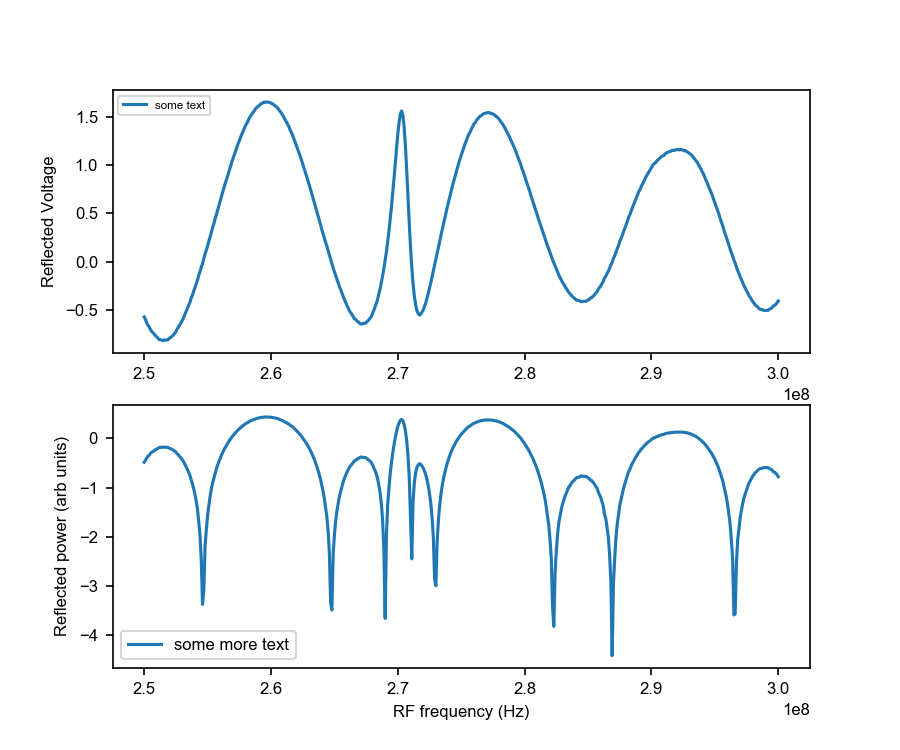

In [17]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(6,5))
ax1.plot(frequency, V_ref ,label="some text")
ax2.plot(frequency, P_ref, label="some more text")
ax1.legend(loc='upper left', fontsize='x-small')
ax1.set_ylabel('Reflected Voltage')
ax2.set_xlabel('RF frequency (Hz)')
ax2.set_ylabel('Reflected power (arb units)')
ax2.legend()

In [26]:
sr1.sine_outdc()

C:\ProgramData\Anaconda3\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


0.0099999997765

## Add some safeties for ramping voltages

In [38]:
#Ramp at a well-defined rate for bias from the SR860 lockin
def biasramp(Vset):
    delay = 0.02 # [s]
    Vstep = 100e-6 #[V]
    
    Vstart = sr1.sine_outdc()    
    voltage = np.linspace(Vstart,Vset,int(abs(Vstart-Vset)/Vstep))    
    for i in range(len(voltage)):
        sr1.sine_outdc(voltage[i])
        time.sleep(delay)

In [43]:
t0 = time.time()
biasramp(0.0)
t1 = time.time()
print('Time to ramp: ' + str(t1 - t0) + 's')

C:\ProgramData\Anaconda3\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


Time to ramp: 2.0846917629241943s


In [48]:
#Ramp at a well defined rate with Yokogawa voltage source
Vset = 0.0
step = 100e-6
delay = 0.02
t0 = time.time()
yoko.ramp_voltage(Vset, step, delay)
t1 = time.time()
print('Time to ramp: ' + str(t1 - t0) + 's')

Time to ramp: 2.0104191303253174s
